In [3]:
 import torch
 import torch.nn as nn
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 

# 1.Regression problem: predict taxi fares

# convert data into format that we can use

In [4]:
df = pd.read_csv('/content/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

The haversine formula calculates the distance on a sphere between two sets of GPS coordinates.

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [8]:
df['dist_km'] = haversine_distance(df, 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.925522
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.765370
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.818373
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.158661
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.457764


In [9]:
df['pickup_datetime'].str[:19], df['pickup_datetime'][0]

(0         2010-04-19 08:17:56
 1         2010-04-17 15:43:53
 2         2010-04-17 11:23:26
 3         2010-04-11 21:25:03
 4         2010-04-17 02:19:01
                  ...         
 119995    2010-04-18 14:33:03
 119996    2010-04-23 10:27:48
 119997    2010-04-18 18:50:40
 119998    2010-04-13 08:14:44
 119999    2010-04-17 16:00:14
 Name: pickup_datetime, Length: 120000, dtype: object,
 '2010-04-19 08:17:56 UTC')

In [10]:
# convert from UTC time to EDT time
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] > 12, 'PM', 'AM')
df['Weekday'] = df['EDTdate'].dt.strftime('%a')
df[['EDTdate', 'Hour', 'AMorPM', 'Weekday']]

,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 04:17:56,4,AM,Mon
1,2010-04-17 11:43:53,11,AM,Sat
2,2010-04-17 07:23:26,7,AM,Sat
3,2010-04-11 17:25:03,17,PM,Sun
4,2010-04-16 22:19:01,22,PM,Fri
...,...,...,...,...
119995,2010-04-18 10:33:03,10,AM,Sun
119996,2010-04-23 06:27:48,6,AM,Fri
119997,2010-04-18 14:50:40,14,PM,Sun
119998,2010-04-13 04:14:44,4,AM,Tue


In [11]:
df['EDTdate'].min(), df['EDTdate'].max()

(Timestamp('2010-04-11 00:00:10'), Timestamp('2010-04-24 23:59:42'))

# process categorical data

In [12]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [13]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: object

In [14]:
# convert dtype to category
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_cols = ['fare_amount']
# cont_cols = [col for col in df.columns if col not in cat_cols + y_cols]
cont_cols

['pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude',
 'passenger_count',
 'dist_km']

In [15]:
# convert dtype to category
for cat in cat_cols:
  df[cat] = df[cat].astype('category')
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [16]:
df['AMorPM'].head()

0    AM
1    AM
2    AM
3    PM
4    PM
Name: AMorPM, dtype: category
Categories (2, object): ['AM', 'PM']

In [17]:
df['AMorPM'].cat.categories

Index(['AM', 'PM'], dtype='object')

In [18]:
df['Weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [19]:
df['Weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [20]:
# combine the three categorical columns into one input array using numpy.stack
cats = np.stack([df[cat].cat.codes.values for cat in cat_cols], axis=1)
cats # numpy arr

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  0,  2]], dtype=int8)

In [21]:
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [22]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)
# float32 - Float, float64 - Double
# here conts is float32
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   1.9255],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.7654],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.8184],
        ...,
        [ 40.7498, -73.9886,  40.7078, -74.0115,   3.0000,   2.8595],
        [ 40.7245, -74.0044,  40.7308, -73.9927,   1.0000,   1.3207],
        [ 40.7719, -73.9554,  40.7630, -73.9676,   3.0000,   1.3848]])

In [23]:
df['pickup_latitude'].values

array([40.730521, 40.740558, 40.751118, ..., 40.749772, 40.724529,
       40.77192 ])

In [24]:
y = torch.tensor(df[y_cols].values, dtype=torch.float)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [25]:
cats.shape, conts.shape, y.shape

(torch.Size([120000, 3]), torch.Size([120000, 6]), torch.Size([120000, 1]))

## embedding

In [26]:
cat_cols
df['Hour'].cat.categories.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [27]:
# size of unique values in categorical columns
cat_sizes = [len(df[col].cat.categories.values) for col in cat_cols]
cat_sizes

[24, 2, 7]

In [28]:
emb_sizes = [(size, min(50, (size+1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [29]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [30]:
catz = cats[:2]

In [31]:
embedding = nn.Embedding(10, 3)

input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
input.shape, embedding(input).shape, embedding(input)

(torch.Size([2, 4]),
 torch.Size([2, 4, 3]),
 tensor([[[-0.6331, -0.6922, -0.8473],
          [-1.8389, -0.9246, -0.0782],
          [ 1.1092,  0.1969, -0.8377],
          [ 2.1768,  0.7207,  0.4646]],
 
         [[ 1.1092,  0.1969, -0.8377],
          [ 0.5664, -0.2225,  0.0776],
          [-1.8389, -0.9246, -0.0782],
          [-0.0033,  0.4113, -1.0142]]], grad_fn=<EmbeddingBackward>))

In [32]:
cats.shape

torch.Size([120000, 3])

In [33]:
embeddings = []
for i,e in enumerate(selfembeds):
  # cats[:, i]: all data of each category
  embeddings.append(e(cats[:, i]))
embeddings

[tensor([[ 0.1804,  1.4570,  0.4141,  ..., -0.6160,  1.6979,  0.3069],
         [-0.8938,  0.5300,  0.5422,  ...,  1.4640,  0.1910, -1.2822],
         [ 0.5483,  1.7480,  2.3875,  ...,  0.8004, -0.0590,  1.6289],
         ...,
         [ 0.7095, -0.3874, -0.4188,  ...,  0.2401,  2.0701,  0.4874],
         [ 0.1804,  1.4570,  0.4141,  ..., -0.6160,  1.6979,  0.3069],
         [-1.7078,  1.6388,  3.1720,  ..., -0.1584,  0.2632,  0.0032]],
        grad_fn=<EmbeddingBackward>), tensor([[-0.9320],
         [-0.9320],
         [-0.9320],
         ...,
         [-0.7767],
         [-0.9320],
         [-0.9320]], grad_fn=<EmbeddingBackward>), tensor([[-0.1945, -0.4167,  0.1162, -0.1350],
         [-0.7553, -0.7129, -1.6770,  1.3834],
         [-0.7553, -0.7129, -1.6770,  1.3834],
         ...,
         [-0.6777,  2.3989,  0.2739, -1.4453],
         [-0.8864, -0.8820, -0.5425,  1.5921],
         [-0.7553, -0.7129, -1.6770,  1.3834]], grad_fn=<EmbeddingBackward>)]

In [34]:
len(embeddings)

3

In [35]:
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  0,  2]])

In [36]:
catenated_embeddings = torch.cat(embeddings, 1)
catenated_embeddings

tensor([[ 0.1804,  1.4570,  0.4141,  ..., -0.4167,  0.1162, -0.1350],
        [-0.8938,  0.5300,  0.5422,  ..., -0.7129, -1.6770,  1.3834],
        [ 0.5483,  1.7480,  2.3875,  ..., -0.7129, -1.6770,  1.3834],
        ...,
        [ 0.7095, -0.3874, -0.4188,  ...,  2.3989,  0.2739, -1.4453],
        [ 0.1804,  1.4570,  0.4141,  ..., -0.8820, -0.5425,  1.5921],
        [-1.7078,  1.6388,  3.1720,  ..., -0.7129, -1.6770,  1.3834]],
       grad_fn=<CatBackward>)

## build model 

> the model has 2 hidden layers, each hidden layer includes a linear function, an activation function, a normalization step, a dropout layer


In [37]:
class TabularModel(nn.Module):

    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_sizes))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_size))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [42]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 1, [200, 100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

# train the model

In [47]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)      

In [48]:
batch_size = 60000;
test_size = int(batch_size*0.2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [49]:
len(y_train)

48000

In [51]:
import time

start_time = time.time()
epoches = 300
losses = []

for i in range(epoches):
  i += 1
  y_pred = model(cat_train, cont_train)
  loss = torch.sqrt(criterion(y_pred, y_train))
  losses.append(loss)

  if i%25==1:
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(f'epoch: {i:3} loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1 loss: 12.57499886
epoch:  26 loss: 3.72430205
epoch:  51 loss: 3.43694711
epoch:  76 loss: 3.36614203
epoch: 101 loss: 3.31723976
epoch: 126 loss: 3.25141239
epoch: 151 loss: 3.20358706
epoch: 176 loss: 3.21636868
epoch: 201 loss: 3.19243622
epoch: 226 loss: 3.17674613
epoch: 251 loss: 3.14814067
epoch: 276 loss: 3.13716316
epoch: 300 loss: 3.12375641

Duration: 265 seconds


# training result
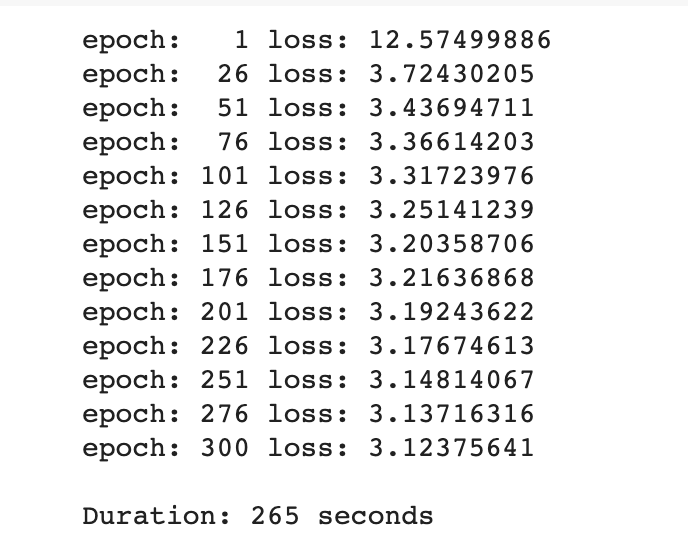


# plot the loss function

Text(0, 0.5, 'loss')

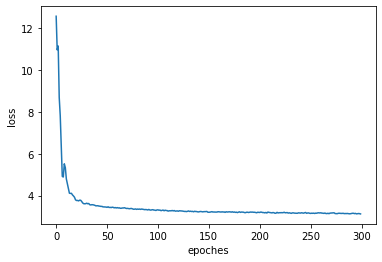

In [53]:
plt.plot(range(epoches), losses)
plt.xlabel('epoches')
plt.ylabel('loss')

# validate the model

In [55]:
with torch.no_grad():
  y_val = model(cat_test, cont_test)
  loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.06112242


This means that on average, predicted values are within ±$3.31 of the actual value.

In [68]:
def show_validate_result(y_val, y_test):
  print(f'{"Predicted":>12} {"Actual":>8} {"Diff":>8}')
  for i in range(50):
    diff = np.abs(y_test[i].item() - y_val[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')
  

In [69]:
show_validate_result(y_val, y_test)

   Predicted   Actual     Diff
 1.   4.4516   2.9000   1.5516
 2.  21.8186   5.7000  16.1186
 3.   6.3600   7.7000   1.3400
 4.  12.4184  12.5000   0.0816
 5.   4.9301   4.1000   0.8301
 6.   5.6383   5.3000   0.3383
 7.   4.3457   3.7000   0.6457
 8.  16.5790  14.5000   2.0790
 9.   5.3905   5.7000   0.3095
10.  12.4904  10.1000   2.3904
11.   5.8140   4.5000   1.3140
12.   6.6557   6.1000   0.5557
13.   7.9384   6.9000   1.0384
14.  13.4953  14.1000   0.6047
15.   5.4915   4.5000   0.9915
16.  34.2486  34.1000   0.1486
17.   4.4576  12.5000   8.0424
18.   5.2266   4.1000   1.1266
19.   9.2870   8.5000   0.7870
20.   6.1875   5.3000   0.8875
21.  14.6558  11.3000   3.3558
22.  10.6644  10.5000   0.1644
23.  16.1392  15.3000   0.8392
24.  17.6619  14.9000   2.7619
25.  47.8371  49.5700   1.7329
26.   6.0385   5.3000   0.7385
27.   5.5407   3.7000   1.8407
28.   8.2290   6.5000   1.7290
29.  14.5324  14.1000   0.4324
30.   5.7382   4.9000   0.8382
31.   5.4106   3.7000   1.7106
32.  36.

# save and load the model

In [60]:
# save the model only after training happened
if len(losses) == epoches:
  torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
  print('Model has not been trained')

In [61]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

class TabularModel(nn.Module):

    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_sizes))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_size))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [63]:
emb_sizes = [(24, 12), (2, 1), (7, 4)]
loaded_model = TabularModel(emb_sizes, 6, 1, [200, 100], p=0.4)

In [65]:
loaded_model.load_state_dict(torch.load('TaxiFareRegrModel.pt'))
loaded_model.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [73]:
with torch.no_grad():
  y_val_from_loaded_model = loaded_model(cat_test, cont_test)
  loss = np.sqrt(criterion(y_val, y_test))
  print(f'RMSE: {loss:.8f}')

RMSE: 2.87295008


In [74]:
show_validate_result(y_val_from_loaded_model, y_test)

   Predicted   Actual     Diff
 1.   4.4516   2.9000   1.5516
 2.  21.8186   5.7000  16.1186
 3.   6.3600   7.7000   1.3400
 4.  12.4184  12.5000   0.0816
 5.   4.9301   4.1000   0.8301
 6.   5.6383   5.3000   0.3383
 7.   4.3457   3.7000   0.6457
 8.  16.5790  14.5000   2.0790
 9.   5.3905   5.7000   0.3095
10.  12.4904  10.1000   2.3904
11.   5.8140   4.5000   1.3140
12.   6.6557   6.1000   0.5557
13.   7.9384   6.9000   1.0384
14.  13.4953  14.1000   0.6047
15.   5.4915   4.5000   0.9915
16.  34.2486  34.1000   0.1486
17.   4.4576  12.5000   8.0424
18.   5.2266   4.1000   1.1266
19.   9.2870   8.5000   0.7870
20.   6.1875   5.3000   0.8875
21.  14.6558  11.3000   3.3558
22.  10.6644  10.5000   0.1644
23.  16.1392  15.3000   0.8392
24.  17.6619  14.9000   2.7619
25.  47.8371  49.5700   1.7329
26.   6.0385   5.3000   0.7385
27.   5.5407   3.7000   1.8407
28.   8.2290   6.5000   1.7290
29.  14.5324  14.1000   0.4324
30.   5.7382   4.9000   0.8382
31.   5.4106   3.7000   1.7106
32.  36.

# 2.Classification problem: predict whether a taxi fare is greater than or less than $10.0

In [78]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.925522,2010-04-19 04:17:56,4,AM,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.765370,2010-04-17 11:43:53,11,AM,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.818373,2010-04-17 07:23:26,7,AM,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.158661,2010-04-11 17:25:03,17,PM,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.457764,2010-04-16 22:19:01,22,PM,Fri


In [79]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class']  

In [85]:
conts = np.stack([df[col] for col in cont_cols], 1)
conts = 

array([[ 40.730521  , -73.992365  ,  40.744746  , -73.975499  ,
          1.        ,   1.92552186],
       [ 40.740558  , -73.990078  ,  40.744114  , -73.974232  ,
          1.        ,   1.76536972],
       [ 40.751118  , -73.994149  ,  40.766235  , -73.960064  ,
          2.        ,   3.81837279],
       ...,
       [ 40.749772  , -73.988574  ,  40.707799  , -74.011541  ,
          3.        ,   2.85952926],
       [ 40.724529  , -74.004449  ,  40.730765  , -73.992697  ,
          1.        ,   1.32066878],
       [ 40.77192   , -73.955415  ,  40.763015  , -73.967623  ,
          3.        ,   1.38476009]])

In [86]:
# convert label to tensor
# the CrossEntropyLoss function we'll use below expects a 1d y-tensor
y = torch.tensor(df[y_col].values).flatten()
y

tensor([0, 0, 1,  ..., 1, 0, 0])

# define a model


> We use the same processed data, though the training and test dataset will be different



In [96]:
class TabularModel(nn.Module):
  def __init__(self, emb_sizes, n_cont, out_sizes, layers, p=0.5):
      super().__init__()
      self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
      self.emb_drop = nn.Dropout(p)
      self.bn_cont = nn.BatchNorm1d(n_cont)

      layerlist = []
      n_emb = sum((nf for ni,nf in emb_sizes))
      n_in = n_emb + n_cont

      for i in layers:
        layerlist.append(nn.Linear(n_in,i)) 
        layerlist.append(nn.ReLU(inplace=True))
        layerlist.append(nn.BatchNorm1d(i))
        layerlist.append(nn.Dropout(p))
        n_in = i
      layerlist.append(nn.Linear(layers[-1], out_sizes))
      self.layers = nn.Sequential(*layerlist)

  def forward(self, x_cat, x_cont):
      embeddings = []
      for i,e in enumerate(self.embeds):
          embeddings.append(e(x_cat[:,i]))
      x = torch.cat(embeddings, 1)
      x = self.emb_drop(x)
      
      x_cont = self.bn_cont(x_cont)
      x = torch.cat([x, x_cont], 1)
      x = self.layers(x)
      return x

In [97]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 2, [200, 100], p=0.4)

In [98]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [99]:
# user CrossEntropyLoss for classification problem
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [113]:
conts = torch.tensor(conts, dtype=torch.float)

In [114]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [115]:
con_train

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   1.9255],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.7654],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.8184],
        ...,
        [ 40.7261, -73.9894,  40.7252, -73.9948,   1.0000,   0.6000],
        [ 40.7485, -73.9801,  40.7470, -73.9972,   1.0000,   1.9066],
        [ 40.7450, -73.9979,  40.7727, -73.9180,   1.0000,   8.9237]])

# train the model

In [118]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.82007974
epoch:  26  loss: 0.35441700
epoch:  51  loss: 0.30306113
epoch:  76  loss: 0.29102090
epoch: 101  loss: 0.28535074
epoch: 126  loss: 0.27807203
epoch: 151  loss: 0.27100441
epoch: 176  loss: 0.26509798
epoch: 201  loss: 0.25816467
epoch: 226  loss: 0.25240576
epoch: 251  loss: 0.24956149
epoch: 276  loss: 0.24668315
epoch: 300  loss: 0.24557728

Duration: 270 seconds


# training result
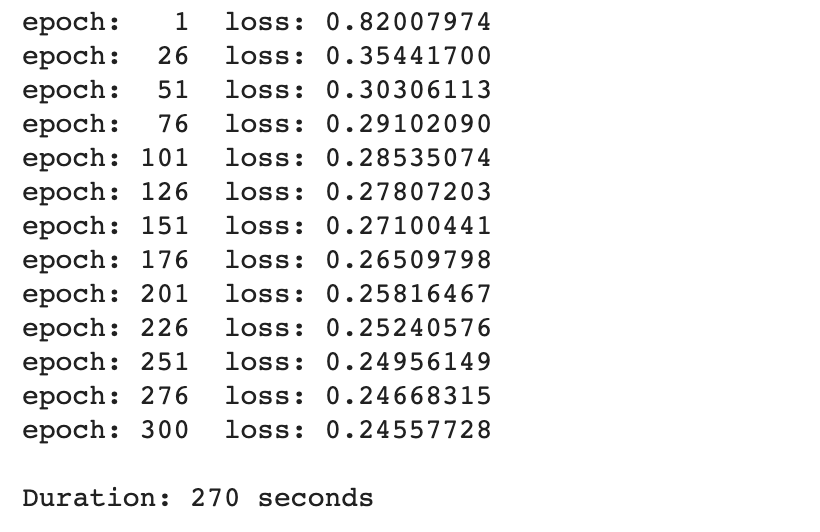

# plot the loss function

Text(0, 0.5, 'loss')

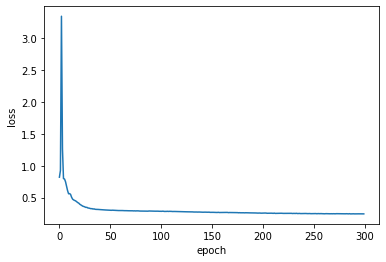

In [138]:
plt.plot(range(epoches), losses)
plt.xlabel('epoch')
plt.ylabel('loss')

# validate the model

In [164]:
def validate_model(cat_test, con_test):
  with torch.no_grad():
    classi_y_val = model(cat_test, con_test)
    print(classi_y_val)
    loss = criterion(classi_y_val, y_test)
  print(f'CE Loss: {loss:.8f}')
  return classi_y_val

In [165]:
classi_y_val = validate_model(cat_test, cont_test)

tensor([[ 2.9671, -0.6672],
        [-2.4198,  2.3659],
        [ 2.6392, -1.9103],
        ...,
        [ 2.2816, -1.9863],
        [ 2.0039, -1.4829],
        [-7.2887,  6.4100]])
CE Loss: 0.23974533


In [166]:
def show_predicted_values(y_val):
  rows = 50
  correct = 0
  print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
  for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7} {y_test[i]:^7}')
    # print(f'{y_val[i].item():.4f} {y_val[i].argmax():^7} {y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
      correct += 1
  print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

In [167]:
classi_y_val
show_predicted_values(classi_y_val)

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.9671, -0.6672])    0       0   
tensor([-2.4198,  2.3659])    1       0   
tensor([ 2.6392, -1.9103])    0       0   
tensor([-1.2908,  1.4407])    1       1   
tensor([ 2.4776, -1.6994])    0       0   
tensor([ 2.0133, -1.9521])    0       0   
tensor([ 2.2855, -2.0101])    0       0   
tensor([-1.7768,  1.7438])    1       1   
tensor([ 2.2679, -1.7606])    0       0   
tensor([-0.8565,  0.9928])    1       1   
tensor([ 1.7821, -1.2733])    0       0   
tensor([ 2.0680, -1.8261])    0       0   
tensor([ 1.9222, -1.7870])    0       0   
tensor([-0.8694,  0.9622])    1       1   
tensor([ 1.6123, -1.5851])    0       0   
tensor([-1.2065,  2.4047])    1       1   
tensor([ 2.4386, -0.7641])    0       1   
tensor([ 2.0944, -1.9801])    0       0   
tensor([ 0.9323, -0.7745])    0       0   
tensor([ 1.9133, -1.6252])    0       0   
tensor([-1.9290,  1.5536])    1       1   
tensor([ 0.5331, -0.2994])    0       1   
tensor([-2.9